In [1]:
import os
import pathlib
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import numpy as np
import librosa
import librosa.display as ld
from IPython.display import Audio
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Activation, Conv1D, Dense, Dropout, Flatten, MaxPool1D, MaxPooling1D, MaxPooling2D
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import seaborn as sns
import pandas as pd
sns.set()

{FOLD}-{CLIP_ID}-{TAKE}-{TARGET}.wav

    - {FOLD}- índice da dobra de validação cruzada,
    - {CLIP_ID}- ID do clipe original do Freesound,
    - {TAKE}- carta desambiguando entre diferentes fragmentos do mesmo clipe Freesound,
    - {TARGET}- classe em formato numérico [0, 49]


In [2]:
archive = pd.read_csv('ESC-50/meta/esc50.csv')
fold = []
clip_id = []
take = []
target = []
dirpath = []

for root, dirs, filename in tqdm(os.walk('ESC-50/audio')):
    for file in filename:

        try:
            fold.append(file.split('-')[0])
            clip_id.append(file.split('-')[1])
            take.append(file.split('-')[2])
            target.append(file.split('-')[3].replace('.wav',''))

            dirpath.append((root, file))

        except ValueError:
            continue

1it [00:00,  2.04it/s]


In [3]:

category = archive[['target','category']]
category['target']= category['target'].astype(str)
category = dict(category.drop_duplicates().values)

In [4]:
df = pd.DataFrame([fold, clip_id, take, target, dirpath]).T
df.columns = ['fold', 'clip_id', 'take', 'target', 'dirpath']
df['category'] = df['target'].map(category)
df['path'] = df['dirpath'].apply(lambda x: x[0] + '/' + x[1])

In [5]:
df

,fold,clip_id,take,target,dirpath,category,path
0,1,100032,A,0,"(ESC-50/audio, 1-100032-A-0.wav)",dog,ESC-50/audio/1-100032-A-0.wav
1,1,100038,A,14,"(ESC-50/audio, 1-100038-A-14.wav)",chirping_birds,ESC-50/audio/1-100038-A-14.wav
2,1,100210,A,36,"(ESC-50/audio, 1-100210-A-36.wav)",vacuum_cleaner,ESC-50/audio/1-100210-A-36.wav
3,1,100210,B,36,"(ESC-50/audio, 1-100210-B-36.wav)",vacuum_cleaner,ESC-50/audio/1-100210-B-36.wav
4,1,101296,A,19,"(ESC-50/audio, 1-101296-A-19.wav)",thunderstorm,ESC-50/audio/1-101296-A-19.wav
...,...,...,...,...,...,...,...
1995,5,263831,B,6,"(ESC-50/audio, 5-263831-B-6.wav)",hen,ESC-50/audio/5-263831-B-6.wav
1996,5,263902,A,36,"(ESC-50/audio, 5-263902-A-36.wav)",vacuum_cleaner,ESC-50/audio/5-263902-A-36.wav
1997,5,51149,A,25,"(ESC-50/audio, 5-51149-A-25.wav)",footsteps,ESC-50/audio/5-51149-A-25.wav
1998,5,61635,A,8,"(ESC-50/audio, 5-61635-A-8.wav)",sheep,ESC-50/audio/5-61635-A-8.wav


In [6]:
df['category'].value_counts()

dog                 40
glass_breaking      40
drinking_sipping    40
rain                40
insects             40
laughing            40
hen                 40
engine              40
breathing           40
crying_baby         40
hand_saw            40
coughing            40
snoring             40
chirping_birds      40
toilet_flush        40
pig                 40
washing_machine     40
clock_tick          40
sneezing            40
rooster             40
sea_waves           40
siren               40
cat                 40
door_wood_creaks    40
helicopter          40
crackling_fire      40
car_horn            40
brushing_teeth      40
vacuum_cleaner      40
thunderstorm        40
door_wood_knock     40
can_opening         40
crow                40
clapping            40
fireworks           40
chainsaw            40
airplane            40
mouse_click         40
pouring_water       40
train               40
sheep               40
water_drops         40
church_bells        40
clock_alarm

Canais:  1
Numero total de amostras:  220500
Arquivo:  ESC-50/audio/3-164595-A-15.wav
Taxa de Amostragem:  44100
['3' '164595' 'A' '15' ('ESC-50/audio', '3-164595-A-15.wav') 'water_drops'
 'ESC-50/audio/3-164595-A-15.wav']


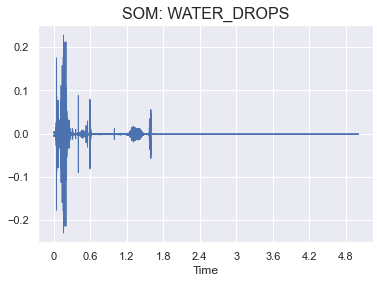

In [25]:

rdn = np.random.randint(1, df.shape[0])
fname = df['path'][rdn]

data, sample_rate = librosa.load(fname, sr=None)

print("Canais: ", len(data.shape))
print("Numero total de amostras: ", data.shape[0])
print("Arquivo: ", fname)
print("Taxa de Amostragem: ", sample_rate)

info = df.iloc[rdn].values
print(info)
title_txt = "Som: " + info[5]
plt.title(title_txt.upper(), size = 16)
librosa.display.waveshow(data ,sr = sample_rate)
Audio(data= data, rate= sample_rate)

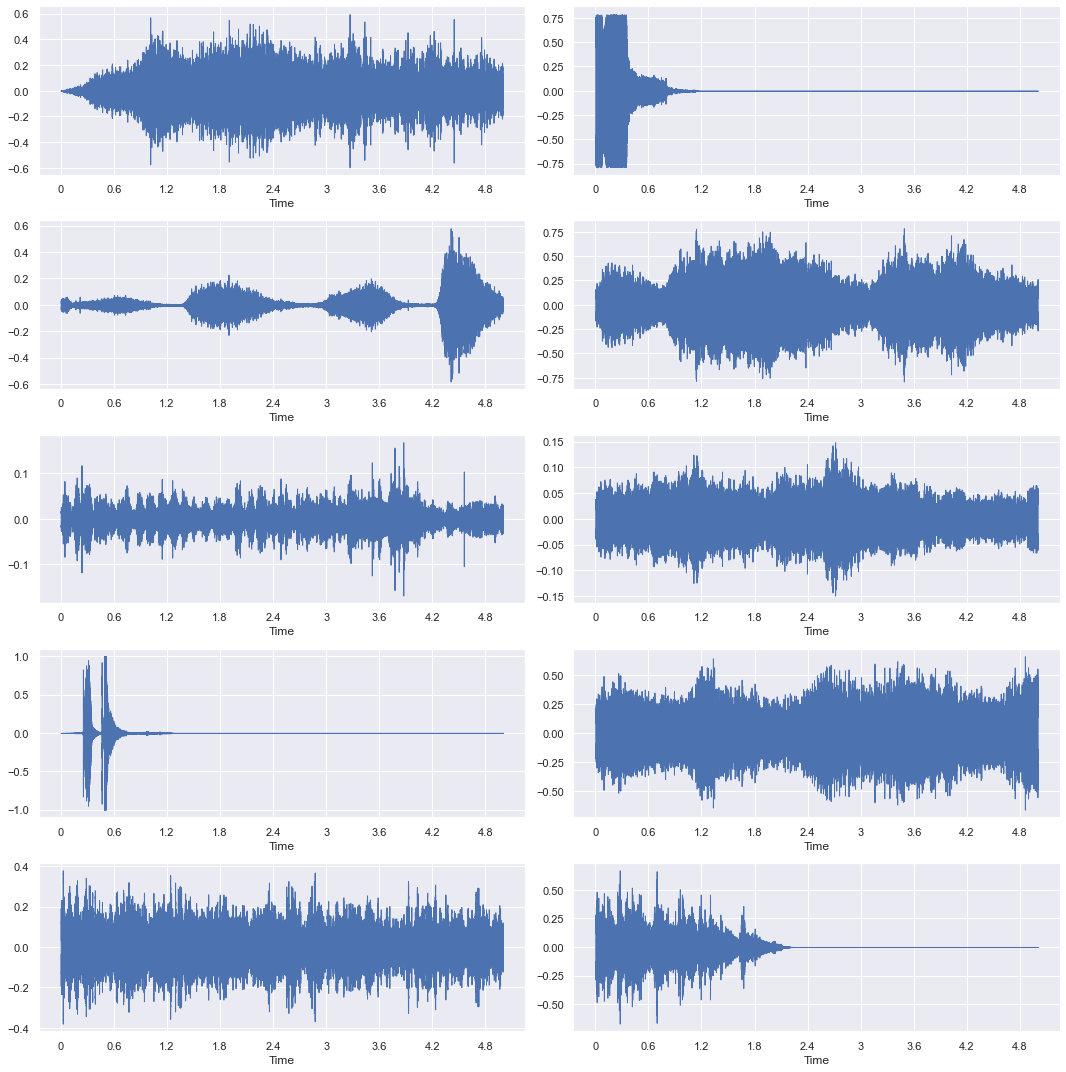

In [8]:
random_samples = df.groupby('category').sample(1)
audio_samples, labels = random_samples['path'].tolist(), random_samples['category']
rows = 5
cols = 2
fig, axs = plt.subplots(rows, cols, figsize=(15,15))
index = 0
for col in range(cols):
    for row in range(rows):
        data, sample_rate = librosa.load(audio_samples[index], sr=None)
        librosa.display.waveshow(data, sample_rate, ax= axs[row][col])
        #axs[row][col].set_title('{}'.format(labels[index]))
        index += 1
fig.tight_layout()

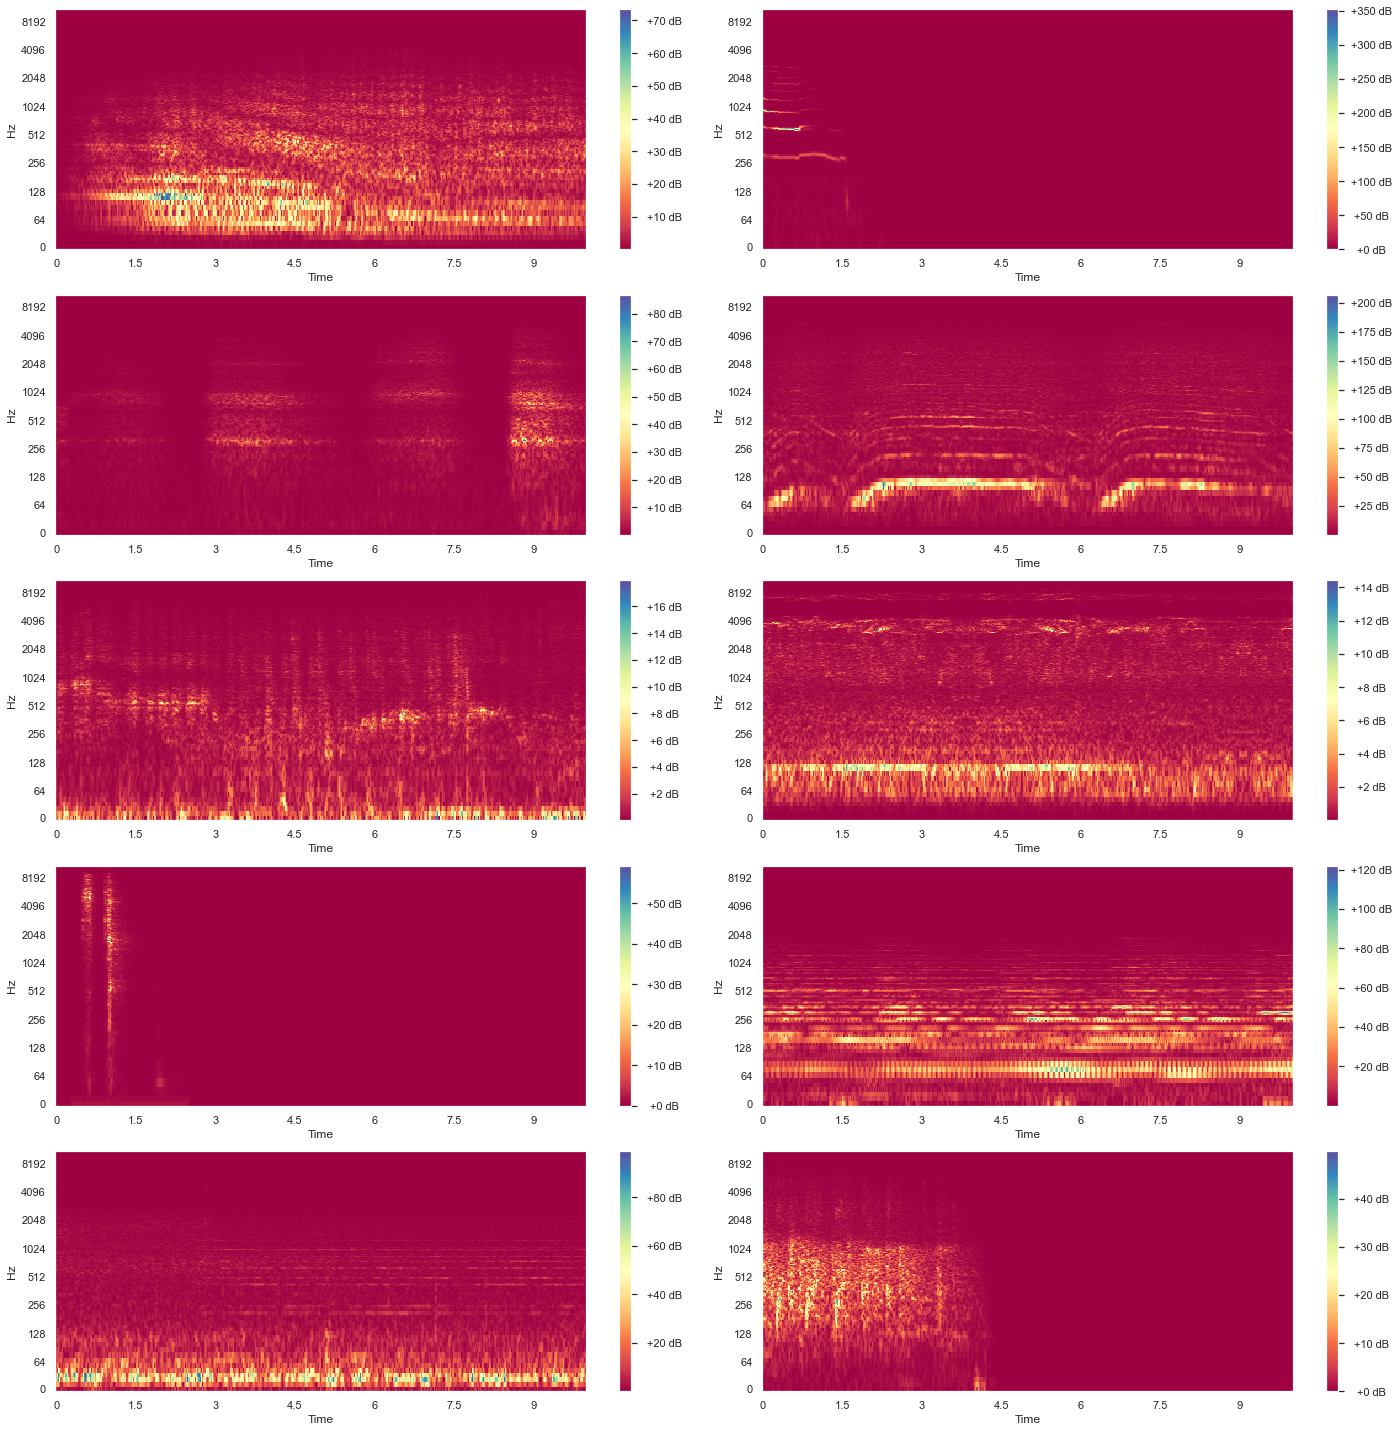

In [9]:
fig, axs = plt.subplots(rows, cols, figsize= (20, 20))
index = 0
for col in range(cols):
    for row in range(rows):
        data, sample_rate = librosa.load(audio_samples[index], sr = None)
        stft = librosa.stft(y = data)
        stft_db = librosa.amplitude_to_db(np.abs(stft))
        img = librosa.display.specshow(stft, x_axis= 'time', y_axis='log', ax = axs[row][col], cmap = 'Spectral')
        #axs[row][col].set_title('{}'.format(labels[index]))
        fig.colorbar(img, ax = axs[row][col], format='%+5.f dB')
        index += 1
fig.tight_layout()


In [10]:
audio_samples, labels

(['ESC-50/audio/3-143562-A-47.wav',
  'ESC-50/audio/3-144128-B-23.wav',
  'ESC-50/audio/5-238938-A-27.wav',
  'ESC-50/audio/2-144031-A-34.wav',
  'ESC-50/audio/2-138465-A-43.wav',
  'ESC-50/audio/5-256452-A-5.wav',
  'ESC-50/audio/5-170338-B-41.wav',
  'ESC-50/audio/4-223125-A-14.wav',
  'ESC-50/audio/1-54747-A-46.wav',
  'ESC-50/audio/5-218494-A-22.wav',
  'ESC-50/audio/2-104475-A-37.wav',
  'ESC-50/audio/4-194711-A-38.wav',
  'ESC-50/audio/2-123896-A-24.wav',
  'ESC-50/audio/5-202795-A-3.wav',
  'ESC-50/audio/2-65747-A-12.wav',
  'ESC-50/audio/4-202749-A-13.wav',
  'ESC-50/audio/5-213836-A-9.wav',
  'ESC-50/audio/4-167077-B-20.wav',
  'ESC-50/audio/5-203128-A-0.wav',
  'ESC-50/audio/5-191497-A-33.wav',
  'ESC-50/audio/2-118625-A-30.wav',
  'ESC-50/audio/5-207836-C-29.wav',
  'ESC-50/audio/3-141240-B-44.wav',
  'ESC-50/audio/1-160563-A-48.wav',
  'ESC-50/audio/1-155858-F-25.wav',
  'ESC-50/audio/1-18757-A-4.wav',
  'ESC-50/audio/2-112213-A-39.wav',
  'ESC-50/audio/5-253101-C-49.wav',


Canais:  1
Numero total de amostras:  220500
Arquivo:  ESC-50/audio/5-256452-A-5.wav
Taxa de Amostragem:  44100
['5' '256452' 'A' '5' ('ESC-50/audio', '5-256452-A-5.wav') 'cat'
 'ESC-50/audio/5-256452-A-5.wav']


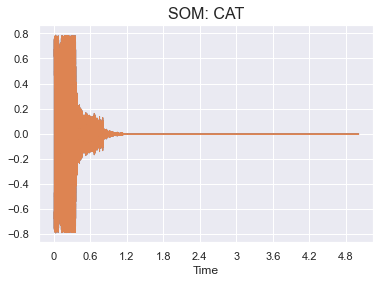

In [26]:
def get_audio(df, pathname):
    rdn = df[df['path'] == f'{pathname}'].index[0]
    fname = df['path'][rdn]

    data, sample_rate = librosa.load(fname, sr=None)

    print("Canais: ", len(data.shape))
    print("Numero total de amostras: ", data.shape[0])
    print("Arquivo: ", fname)
    print("Taxa de Amostragem: ", sample_rate)

    info = df.iloc[rdn].values
    print(info)
    title_txt = "Som: " + info[5]
    plt.title(title_txt.upper(), size = 16)
    librosa.display.waveshow(data ,sr = sample_rate)
    Audio(data= data, rate= sample_rate)
    return data, sample_rate

data, sample_rate = get_audio(df, 'ESC-50/audio/5-256452-A-5.wav')
librosa.display.waveshow(data ,sr = sample_rate)
Audio(data= data, rate= sample_rate)

In [12]:
df[df['path'] == 'ESC-50/audio/2-96654-A-47.wav'].index[0]

790

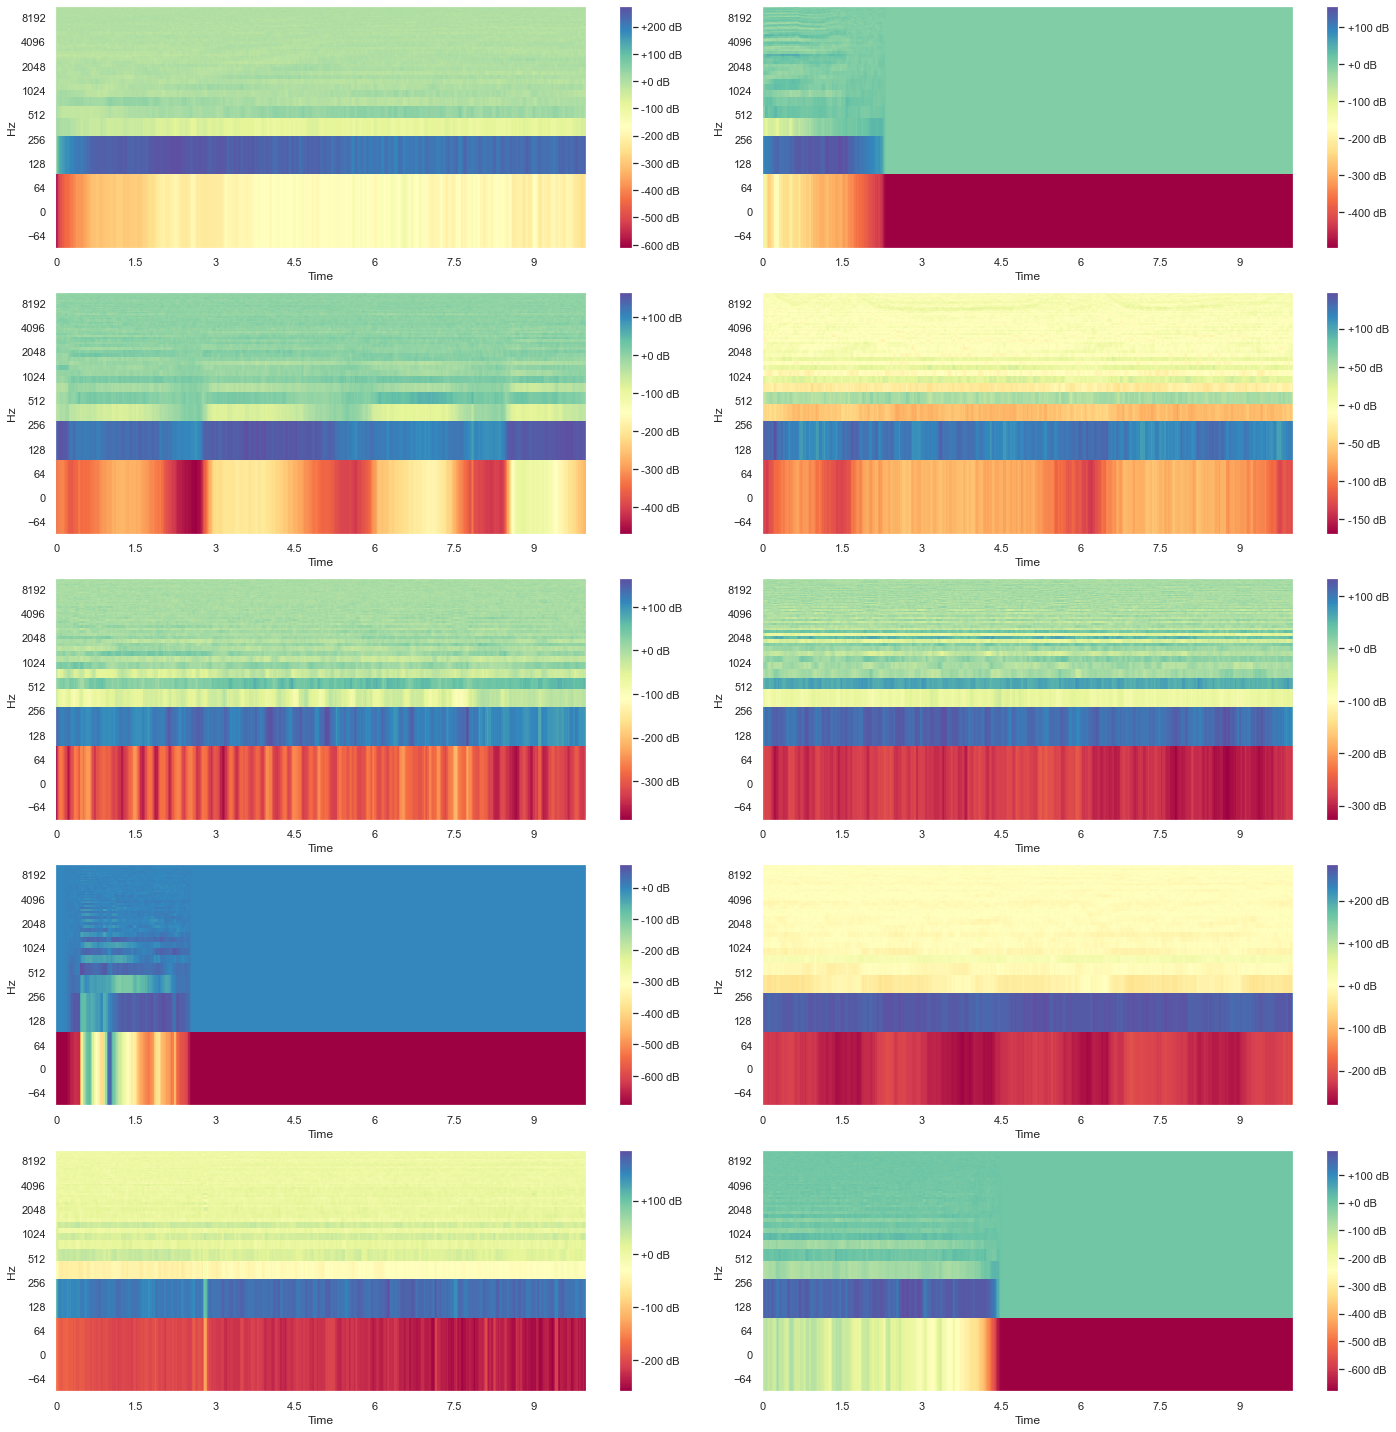

In [13]:
fig, axs = plt.subplots(rows, cols, figsize= (20, 20))
index = 0
for col in range(cols):
    for row in range(rows):
        data, sample_rate = librosa.load(audio_samples[index], sr = None)
        mfccs = librosa.feature.mfcc(y = data, sr=sample_rate, n_mfcc = 60)
        mfcc_db = librosa.amplitude_to_db(np.abs(mfccs))
        img = librosa.display.specshow(mfccs, x_axis= 'time', y_axis='log', ax = axs[row][col], cmap = 'Spectral')
        #axs[row][col].set_title('{}'.format(labels[index]))
        fig.colorbar(img, ax = axs[row][col], format='%+2.f dB')
        index += 1
fig.tight_layout()

In [46]:
def features_extractor(file_name):
    data, sample_rate = librosa.load(file_name, sr=None, res_type='kaiser_fast')
    mfccs_features = librosa.feature.mfcc(y = data, sr=sample_rate, n_mfcc=60)
    mfccs_features_scaled = np.mean(mfccs_features.T, axis = 0)
    
    return mfccs_features

In [7]:
extracted_features = []
for path in tqdm(df['path'].values):
    data = features_extractor(path)
    extracted_features.append([data])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [02:27<00:00, 13.53it/s]


In [68]:
extracted_features_df = pd.DataFrame(extracted_features, columns=['feature'])
extracted_features_df.head(1)['feature'].values



array([array([-5.81739929e+02,  8.20712185e+00, -6.65880251e+00, -4.29090643e+00,
              -3.03447795e+00,  2.59279221e-01, -1.96394646e+00, -2.71576792e-01,
               5.18284082e-01,  3.41884226e-01,  9.06101882e-01, -9.52457078e-03,
              -1.90549478e-01, -1.32677212e-01, -6.07613385e-01, -7.14699551e-02,
               2.63702869e-01,  2.50987392e-02, -2.88374722e-01, -8.00329387e-01,
              -3.57852399e-01, -1.31652847e-01,  1.15360126e-01,  2.61937410e-01,
              -3.45040083e-01, -6.39805794e-01,  1.31995291e-01,  2.67431974e-01,
              -4.31778699e-01, -1.38551667e-01, -1.56152517e-01, -1.92928523e-01,
               4.53132913e-02,  1.35319605e-01, -3.72374743e-01, -1.90798283e-01,
              -3.43015082e-02,  4.61393505e-01,  3.62329967e-02,  1.06095932e-01,
              -1.01134971e-01, -2.60801643e-01, -2.70745426e-01,  1.72611639e-01,
               4.01726030e-02, -1.69511199e-01,  8.75895545e-02, -1.39346728e-02,
               1

In [79]:
x = np.array(extracted_features_df['feature'].to_list())
y = np.array(df['category'].to_list())

In [80]:
labelencoder = LabelEncoder()
y = to_categorical(labelencoder.fit_transform(y))


In [81]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.20, random_state= 1)
x_test, x_val, y_test, y_val = train_test_split(x_test,y_test, test_size=0.50, random_state= 1)

In [82]:
print(x_test.shape)
print(x_val.shape)

(200, 60)
(200, 60)


In [83]:
y_train.shape

(1600, 50)

In [62]:
x_train = x_train[:,:,np.newaxis]
x_test = x_test[:,:,np.newaxis]
x_val = x_val[:,:,np.newaxis]

In [89]:
x_train.shape

(1600, 60)

In [64]:
model = Sequential()
model.add(Conv1D(64, kernel_size =(10), activation = 'relu', input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.4))
model.add(MaxPooling1D(pool_size=(4)))

model.add(Conv1D(128, 10, padding='same', activation = 'relu'))
model.add(Dropout(0.4))
model.add(MaxPooling1D(pool_size = (4)))

model.add(Flatten())
model.add(Dense(units = 64))
model.add(Dropout(0.4))
model.add(Dense(units = 50))
model.add(Activation('softmax'))

In [65]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_20 (Conv1D)          (None, 51, 64)            704       
                                                                 
 dropout_19 (Dropout)        (None, 51, 64)            0         
                                                                 
 max_pooling1d_18 (MaxPoolin  (None, 12, 64)           0         
 g1D)                                                            
                                                                 
 conv1d_21 (Conv1D)          (None, 12, 128)           82048     
                                                                 
 dropout_20 (Dropout)        (None, 12, 128)           0         
                                                                 
 max_pooling1d_19 (MaxPoolin  (None, 3, 128)           0         
 g1D)                                                

In [66]:
num_epochs = 160
num_batch_sizes = 32

checkpointer = ModelCheckpoint(filepath='save_models/sound_classification.hdfs5', verbose= 1, save_best_only= True)
start = datetime.now()
history = model.fit(x_train, y_train, batch_size= num_batch_sizes, epochs= num_epochs, validation_data=(x_val, y_val), callbacks=checkpointer, verbose=1)
duration = datetime.now() - start
print("Duration: ", duration)

Epoch 1/160
43/50 [========================>.....] - ETA: 0s - loss: 7.3584 - accuracy: 0.0392
Epoch 1: val_loss improved from inf to 3.66747, saving model to save_models\sound_classification.hdfs5


INFO:tensorflow:Assets written to: save_models\sound_classification.hdfs5\assets


INFO:tensorflow:Assets written to: save_models\sound_classification.hdfs5\assets


50/50 [==============================] - 6s 67ms/step - loss: 6.8806 - accuracy: 0.0419 - val_loss: 3.6675 - val_accuracy: 0.0600
Epoch 2/160
50/50 [==============================] - ETA: 0s - loss: 3.8499 - accuracy: 0.0631
Epoch 2: val_loss improved from 3.66747 to 3.57179, saving model to save_models\sound_classification.hdfs5


INFO:tensorflow:Assets written to: save_models\sound_classification.hdfs5\assets


INFO:tensorflow:Assets written to: save_models\sound_classification.hdfs5\assets


50/50 [==============================] - 3s 66ms/step - loss: 3.8499 - accuracy: 0.0631 - val_loss: 3.5718 - val_accuracy: 0.1250
Epoch 3/160
45/50 [==========================>...] - ETA: 0s - loss: 3.6632 - accuracy: 0.0896
Epoch 3: val_loss improved from 3.57179 to 3.42935, saving model to save_models\sound_classification.hdfs5


INFO:tensorflow:Assets written to: save_models\sound_classification.hdfs5\assets


INFO:tensorflow:Assets written to: save_models\sound_classification.hdfs5\assets


50/50 [==============================] - 2s 51ms/step - loss: 3.6561 - accuracy: 0.0906 - val_loss: 3.4293 - val_accuracy: 0.1650
Epoch 4/160
49/50 [============================>.] - ETA: 0s - loss: 3.5194 - accuracy: 0.1084
Epoch 4: val_loss improved from 3.42935 to 3.27681, saving model to save_models\sound_classification.hdfs5


INFO:tensorflow:Assets written to: save_models\sound_classification.hdfs5\assets


INFO:tensorflow:Assets written to: save_models\sound_classification.hdfs5\assets


50/50 [==============================] - 2s 46ms/step - loss: 3.5197 - accuracy: 0.1075 - val_loss: 3.2768 - val_accuracy: 0.1800
Epoch 5/160
50/50 [==============================] - ETA: 0s - loss: 3.3338 - accuracy: 0.1287
Epoch 5: val_loss improved from 3.27681 to 3.11674, saving model to save_models\sound_classification.hdfs5


INFO:tensorflow:Assets written to: save_models\sound_classification.hdfs5\assets


INFO:tensorflow:Assets written to: save_models\sound_classification.hdfs5\assets


50/50 [==============================] - 2s 45ms/step - loss: 3.3338 - accuracy: 0.1287 - val_loss: 3.1167 - val_accuracy: 0.2450
Epoch 6/160
49/50 [============================>.] - ETA: 0s - loss: 3.2228 - accuracy: 0.1684
Epoch 6: val_loss improved from 3.11674 to 2.97943, saving model to save_models\sound_classification.hdfs5


INFO:tensorflow:Assets written to: save_models\sound_classification.hdfs5\assets


INFO:tensorflow:Assets written to: save_models\sound_classification.hdfs5\assets


50/50 [==============================] - 3s 53ms/step - loss: 3.2102 - accuracy: 0.1688 - val_loss: 2.9794 - val_accuracy: 0.3100
Epoch 7/160
49/50 [============================>.] - ETA: 0s - loss: 3.0584 - accuracy: 0.1894
Epoch 7: val_loss improved from 2.97943 to 2.88968, saving model to save_models\sound_classification.hdfs5


INFO:tensorflow:Assets written to: save_models\sound_classification.hdfs5\assets


INFO:tensorflow:Assets written to: save_models\sound_classification.hdfs5\assets


50/50 [==============================] - 3s 59ms/step - loss: 3.0569 - accuracy: 0.1912 - val_loss: 2.8897 - val_accuracy: 0.2600
Epoch 8/160
50/50 [==============================] - ETA: 0s - loss: 2.9851 - accuracy: 0.1937
Epoch 8: val_loss improved from 2.88968 to 2.79614, saving model to save_models\sound_classification.hdfs5


INFO:tensorflow:Assets written to: save_models\sound_classification.hdfs5\assets


INFO:tensorflow:Assets written to: save_models\sound_classification.hdfs5\assets


50/50 [==============================] - 2s 44ms/step - loss: 2.9851 - accuracy: 0.1937 - val_loss: 2.7961 - val_accuracy: 0.3450
Epoch 9/160
45/50 [==========================>...] - ETA: 0s - loss: 2.8717 - accuracy: 0.2368
Epoch 9: val_loss improved from 2.79614 to 2.73003, saving model to save_models\sound_classification.hdfs5


INFO:tensorflow:Assets written to: save_models\sound_classification.hdfs5\assets


INFO:tensorflow:Assets written to: save_models\sound_classification.hdfs5\assets


50/50 [==============================] - 2s 45ms/step - loss: 2.8736 - accuracy: 0.2375 - val_loss: 2.7300 - val_accuracy: 0.3100
Epoch 10/160
44/50 [=========================>....] - ETA: 0s - loss: 2.7424 - accuracy: 0.2479
Epoch 10: val_loss improved from 2.73003 to 2.61677, saving model to save_models\sound_classification.hdfs5


INFO:tensorflow:Assets written to: save_models\sound_classification.hdfs5\assets


INFO:tensorflow:Assets written to: save_models\sound_classification.hdfs5\assets


50/50 [==============================] - 3s 61ms/step - loss: 2.7671 - accuracy: 0.2450 - val_loss: 2.6168 - val_accuracy: 0.3500
Epoch 11/160
50/50 [==============================] - ETA: 0s - loss: 2.6680 - accuracy: 0.2594
Epoch 11: val_loss improved from 2.61677 to 2.61586, saving model to save_models\sound_classification.hdfs5


INFO:tensorflow:Assets written to: save_models\sound_classification.hdfs5\assets


INFO:tensorflow:Assets written to: save_models\sound_classification.hdfs5\assets


50/50 [==============================] - 2s 48ms/step - loss: 2.6680 - accuracy: 0.2594 - val_loss: 2.6159 - val_accuracy: 0.3600
Epoch 12/160
49/50 [============================>.] - ETA: 0s - loss: 2.6014 - accuracy: 0.2895
Epoch 12: val_loss improved from 2.61586 to 2.54628, saving model to save_models\sound_classification.hdfs5


INFO:tensorflow:Assets written to: save_models\sound_classification.hdfs5\assets


INFO:tensorflow:Assets written to: save_models\sound_classification.hdfs5\assets


50/50 [==============================] - 2s 50ms/step - loss: 2.5969 - accuracy: 0.2919 - val_loss: 2.5463 - val_accuracy: 0.3100
Epoch 13/160
49/50 [============================>.] - ETA: 0s - loss: 2.5408 - accuracy: 0.3093
Epoch 13: val_loss did not improve from 2.54628
50/50 [==============================] - 1s 10ms/step - loss: 2.5484 - accuracy: 0.3069 - val_loss: 2.5779 - val_accuracy: 0.3850
Epoch 14/160
48/50 [===========================>..] - ETA: 0s - loss: 2.5045 - accuracy: 0.3040
Epoch 14: val_loss improved from 2.54628 to 2.46825, saving model to save_models\sound_classification.hdfs5


INFO:tensorflow:Assets written to: save_models\sound_classification.hdfs5\assets


INFO:tensorflow:Assets written to: save_models\sound_classification.hdfs5\assets


50/50 [==============================] - 2s 49ms/step - loss: 2.5181 - accuracy: 0.3013 - val_loss: 2.4683 - val_accuracy: 0.3850
Epoch 15/160
50/50 [==============================] - ETA: 0s - loss: 2.4283 - accuracy: 0.3200
Epoch 15: val_loss did not improve from 2.46825
50/50 [==============================] - 1s 10ms/step - loss: 2.4283 - accuracy: 0.3200 - val_loss: 2.4731 - val_accuracy: 0.4200
Epoch 16/160
50/50 [==============================] - ETA: 0s - loss: 2.3622 - accuracy: 0.3225
Epoch 16: val_loss improved from 2.46825 to 2.35737, saving model to save_models\sound_classification.hdfs5


INFO:tensorflow:Assets written to: save_models\sound_classification.hdfs5\assets


INFO:tensorflow:Assets written to: save_models\sound_classification.hdfs5\assets


50/50 [==============================] - 3s 54ms/step - loss: 2.3622 - accuracy: 0.3225 - val_loss: 2.3574 - val_accuracy: 0.4200
Epoch 17/160
49/50 [============================>.] - ETA: 0s - loss: 2.2362 - accuracy: 0.3552
Epoch 17: val_loss improved from 2.35737 to 2.30539, saving model to save_models\sound_classification.hdfs5


INFO:tensorflow:Assets written to: save_models\sound_classification.hdfs5\assets


INFO:tensorflow:Assets written to: save_models\sound_classification.hdfs5\assets


50/50 [==============================] - 2s 44ms/step - loss: 2.2374 - accuracy: 0.3544 - val_loss: 2.3054 - val_accuracy: 0.3900
Epoch 18/160
50/50 [==============================] - ETA: 0s - loss: 2.2166 - accuracy: 0.3862
Epoch 18: val_loss improved from 2.30539 to 2.29104, saving model to save_models\sound_classification.hdfs5


INFO:tensorflow:Assets written to: save_models\sound_classification.hdfs5\assets


INFO:tensorflow:Assets written to: save_models\sound_classification.hdfs5\assets


50/50 [==============================] - 2s 50ms/step - loss: 2.2166 - accuracy: 0.3862 - val_loss: 2.2910 - val_accuracy: 0.4150
Epoch 19/160
45/50 [==========================>...] - ETA: 0s - loss: 2.2374 - accuracy: 0.3896
Epoch 19: val_loss did not improve from 2.29104
50/50 [==============================] - 1s 12ms/step - loss: 2.2551 - accuracy: 0.3825 - val_loss: 2.3158 - val_accuracy: 0.4550
Epoch 20/160
47/50 [===========================>..] - ETA: 0s - loss: 2.1323 - accuracy: 0.3969
Epoch 20: val_loss improved from 2.29104 to 2.23022, saving model to save_models\sound_classification.hdfs5


INFO:tensorflow:Assets written to: save_models\sound_classification.hdfs5\assets


INFO:tensorflow:Assets written to: save_models\sound_classification.hdfs5\assets


50/50 [==============================] - 3s 53ms/step - loss: 2.1549 - accuracy: 0.3919 - val_loss: 2.2302 - val_accuracy: 0.4100
Epoch 21/160
44/50 [=========================>....] - ETA: 0s - loss: 2.0692 - accuracy: 0.4226
Epoch 21: val_loss improved from 2.23022 to 2.20235, saving model to save_models\sound_classification.hdfs5


INFO:tensorflow:Assets written to: save_models\sound_classification.hdfs5\assets


INFO:tensorflow:Assets written to: save_models\sound_classification.hdfs5\assets


50/50 [==============================] - 3s 59ms/step - loss: 2.1028 - accuracy: 0.4144 - val_loss: 2.2023 - val_accuracy: 0.4050
Epoch 22/160
48/50 [===========================>..] - ETA: 0s - loss: 2.1422 - accuracy: 0.4043
Epoch 22: val_loss did not improve from 2.20235
50/50 [==============================] - 0s 9ms/step - loss: 2.1309 - accuracy: 0.4038 - val_loss: 2.2362 - val_accuracy: 0.4500
Epoch 23/160
46/50 [==========================>...] - ETA: 0s - loss: 2.0718 - accuracy: 0.4158
Epoch 23: val_loss did not improve from 2.20235
50/50 [==============================] - 0s 10ms/step - loss: 2.0621 - accuracy: 0.4156 - val_loss: 2.2132 - val_accuracy: 0.4500
Epoch 24/160
46/50 [==========================>...] - ETA: 0s - loss: 1.9730 - accuracy: 0.4300
Epoch 24: val_loss improved from 2.20235 to 2.12101, saving model to save_models\sound_classification.hdfs5


INFO:tensorflow:Assets written to: save_models\sound_classification.hdfs5\assets


INFO:tensorflow:Assets written to: save_models\sound_classification.hdfs5\assets


50/50 [==============================] - 3s 53ms/step - loss: 1.9852 - accuracy: 0.4281 - val_loss: 2.1210 - val_accuracy: 0.4550
Epoch 25/160
50/50 [==============================] - ETA: 0s - loss: 1.9594 - accuracy: 0.4437
Epoch 25: val_loss did not improve from 2.12101
50/50 [==============================] - 0s 10ms/step - loss: 1.9594 - accuracy: 0.4437 - val_loss: 2.1671 - val_accuracy: 0.4200
Epoch 26/160
44/50 [=========================>....] - ETA: 0s - loss: 1.9252 - accuracy: 0.4411
Epoch 26: val_loss improved from 2.12101 to 2.10831, saving model to save_models\sound_classification.hdfs5


INFO:tensorflow:Assets written to: save_models\sound_classification.hdfs5\assets


INFO:tensorflow:Assets written to: save_models\sound_classification.hdfs5\assets


50/50 [==============================] - 2s 46ms/step - loss: 1.9161 - accuracy: 0.4394 - val_loss: 2.1083 - val_accuracy: 0.4400
Epoch 27/160
46/50 [==========================>...] - ETA: 0s - loss: 1.8964 - accuracy: 0.4490
Epoch 27: val_loss improved from 2.10831 to 2.01332, saving model to save_models\sound_classification.hdfs5


INFO:tensorflow:Assets written to: save_models\sound_classification.hdfs5\assets


INFO:tensorflow:Assets written to: save_models\sound_classification.hdfs5\assets


50/50 [==============================] - 2s 48ms/step - loss: 1.8931 - accuracy: 0.4506 - val_loss: 2.0133 - val_accuracy: 0.5200
Epoch 28/160
46/50 [==========================>...] - ETA: 0s - loss: 1.8635 - accuracy: 0.4599
Epoch 28: val_loss did not improve from 2.01332
50/50 [==============================] - 1s 12ms/step - loss: 1.8660 - accuracy: 0.4594 - val_loss: 2.0318 - val_accuracy: 0.4850
Epoch 29/160
49/50 [============================>.] - ETA: 0s - loss: 1.8220 - accuracy: 0.4726
Epoch 29: val_loss did not improve from 2.01332
50/50 [==============================] - 0s 9ms/step - loss: 1.8200 - accuracy: 0.4706 - val_loss: 2.0668 - val_accuracy: 0.4850
Epoch 30/160
50/50 [==============================] - ETA: 0s - loss: 1.8562 - accuracy: 0.4538
Epoch 30: val_loss improved from 2.01332 to 2.00710, saving model to save_models\sound_classification.hdfs5


INFO:tensorflow:Assets written to: save_models\sound_classification.hdfs5\assets


INFO:tensorflow:Assets written to: save_models\sound_classification.hdfs5\assets


50/50 [==============================] - 2s 42ms/step - loss: 1.8562 - accuracy: 0.4538 - val_loss: 2.0071 - val_accuracy: 0.4850
Epoch 31/160
50/50 [==============================] - ETA: 0s - loss: 1.7896 - accuracy: 0.4787
Epoch 31: val_loss did not improve from 2.00710
50/50 [==============================] - 0s 9ms/step - loss: 1.7896 - accuracy: 0.4787 - val_loss: 2.0137 - val_accuracy: 0.4550
Epoch 32/160
50/50 [==============================] - ETA: 0s - loss: 1.7231 - accuracy: 0.5119
Epoch 32: val_loss improved from 2.00710 to 1.93270, saving model to save_models\sound_classification.hdfs5


INFO:tensorflow:Assets written to: save_models\sound_classification.hdfs5\assets


INFO:tensorflow:Assets written to: save_models\sound_classification.hdfs5\assets


50/50 [==============================] - 2s 43ms/step - loss: 1.7231 - accuracy: 0.5119 - val_loss: 1.9327 - val_accuracy: 0.5200
Epoch 33/160
43/50 [========================>.....] - ETA: 0s - loss: 1.7371 - accuracy: 0.4935
Epoch 33: val_loss did not improve from 1.93270
50/50 [==============================] - 0s 9ms/step - loss: 1.7133 - accuracy: 0.4981 - val_loss: 1.9360 - val_accuracy: 0.5250
Epoch 34/160
44/50 [=========================>....] - ETA: 0s - loss: 1.7023 - accuracy: 0.5092
Epoch 34: val_loss did not improve from 1.93270
50/50 [==============================] - 0s 9ms/step - loss: 1.7281 - accuracy: 0.5031 - val_loss: 1.9875 - val_accuracy: 0.5200
Epoch 35/160
50/50 [==============================] - ETA: 0s - loss: 1.7245 - accuracy: 0.5031
Epoch 35: val_loss improved from 1.93270 to 1.93213, saving model to save_models\sound_classification.hdfs5


INFO:tensorflow:Assets written to: save_models\sound_classification.hdfs5\assets


INFO:tensorflow:Assets written to: save_models\sound_classification.hdfs5\assets


50/50 [==============================] - 2s 43ms/step - loss: 1.7245 - accuracy: 0.5031 - val_loss: 1.9321 - val_accuracy: 0.5300
Epoch 36/160
47/50 [===========================>..] - ETA: 0s - loss: 1.6242 - accuracy: 0.5299
Epoch 36: val_loss did not improve from 1.93213
50/50 [==============================] - 0s 9ms/step - loss: 1.6319 - accuracy: 0.5331 - val_loss: 1.9612 - val_accuracy: 0.5150
Epoch 37/160
50/50 [==============================] - ETA: 0s - loss: 1.6026 - accuracy: 0.5306
Epoch 37: val_loss did not improve from 1.93213
50/50 [==============================] - 0s 9ms/step - loss: 1.6026 - accuracy: 0.5306 - val_loss: 1.9521 - val_accuracy: 0.4950
Epoch 38/160
46/50 [==========================>...] - ETA: 0s - loss: 1.5964 - accuracy: 0.5462
Epoch 38: val_loss did not improve from 1.93213
50/50 [==============================] - 0s 8ms/step - loss: 1.5998 - accuracy: 0.5419 - val_loss: 1.9548 - val_accuracy: 0.4900
Epoch 39/160
50/50 [==============================]

INFO:tensorflow:Assets written to: save_models\sound_classification.hdfs5\assets


INFO:tensorflow:Assets written to: save_models\sound_classification.hdfs5\assets


50/50 [==============================] - 2s 45ms/step - loss: 1.5773 - accuracy: 0.5425 - val_loss: 1.8648 - val_accuracy: 0.5100
Epoch 40/160
48/50 [===========================>..] - ETA: 0s - loss: 1.5199 - accuracy: 0.5430
Epoch 40: val_loss improved from 1.86477 to 1.84577, saving model to save_models\sound_classification.hdfs5


INFO:tensorflow:Assets written to: save_models\sound_classification.hdfs5\assets


INFO:tensorflow:Assets written to: save_models\sound_classification.hdfs5\assets


50/50 [==============================] - 3s 51ms/step - loss: 1.5234 - accuracy: 0.5437 - val_loss: 1.8458 - val_accuracy: 0.5050
Epoch 41/160
47/50 [===========================>..] - ETA: 0s - loss: 1.5423 - accuracy: 0.5372
Epoch 41: val_loss did not improve from 1.84577
50/50 [==============================] - 0s 10ms/step - loss: 1.5416 - accuracy: 0.5344 - val_loss: 1.8553 - val_accuracy: 0.5550
Epoch 42/160
46/50 [==========================>...] - ETA: 0s - loss: 1.5077 - accuracy: 0.5482
Epoch 42: val_loss did not improve from 1.84577
50/50 [==============================] - 0s 10ms/step - loss: 1.5108 - accuracy: 0.5475 - val_loss: 1.8702 - val_accuracy: 0.5450
Epoch 43/160
47/50 [===========================>..] - ETA: 0s - loss: 1.4926 - accuracy: 0.5512
Epoch 43: val_loss did not improve from 1.84577
50/50 [==============================] - 0s 9ms/step - loss: 1.5055 - accuracy: 0.5481 - val_loss: 1.8753 - val_accuracy: 0.5000
Epoch 44/160
47/50 [===========================>.

INFO:tensorflow:Assets written to: save_models\sound_classification.hdfs5\assets


INFO:tensorflow:Assets written to: save_models\sound_classification.hdfs5\assets


50/50 [==============================] - 2s 41ms/step - loss: 1.4692 - accuracy: 0.5644 - val_loss: 1.7776 - val_accuracy: 0.5250
Epoch 45/160
48/50 [===========================>..] - ETA: 0s - loss: 1.4917 - accuracy: 0.5605
Epoch 45: val_loss did not improve from 1.77757
50/50 [==============================] - 0s 9ms/step - loss: 1.4938 - accuracy: 0.5619 - val_loss: 1.8735 - val_accuracy: 0.5000
Epoch 46/160
44/50 [=========================>....] - ETA: 0s - loss: 1.4305 - accuracy: 0.5831
Epoch 46: val_loss did not improve from 1.77757
50/50 [==============================] - 0s 10ms/step - loss: 1.4378 - accuracy: 0.5819 - val_loss: 1.8140 - val_accuracy: 0.5300
Epoch 47/160
47/50 [===========================>..] - ETA: 0s - loss: 1.4159 - accuracy: 0.5971
Epoch 47: val_loss did not improve from 1.77757
50/50 [==============================] - 0s 10ms/step - loss: 1.4271 - accuracy: 0.5931 - val_loss: 1.8457 - val_accuracy: 0.5350
Epoch 48/160
46/50 [==========================>..

INFO:tensorflow:Assets written to: save_models\sound_classification.hdfs5\assets


INFO:tensorflow:Assets written to: save_models\sound_classification.hdfs5\assets


50/50 [==============================] - 2s 41ms/step - loss: 1.3165 - accuracy: 0.6137 - val_loss: 1.7673 - val_accuracy: 0.5750
Epoch 52/160
48/50 [===========================>..] - ETA: 0s - loss: 1.3488 - accuracy: 0.5983
Epoch 52: val_loss did not improve from 1.76726
50/50 [==============================] - 0s 9ms/step - loss: 1.3523 - accuracy: 0.5981 - val_loss: 1.7829 - val_accuracy: 0.5650
Epoch 53/160
48/50 [===========================>..] - ETA: 0s - loss: 1.3397 - accuracy: 0.5918
Epoch 53: val_loss did not improve from 1.76726
50/50 [==============================] - 0s 9ms/step - loss: 1.3461 - accuracy: 0.5938 - val_loss: 1.7684 - val_accuracy: 0.5650
Epoch 54/160
46/50 [==========================>...] - ETA: 0s - loss: 1.2878 - accuracy: 0.6005
Epoch 54: val_loss improved from 1.76726 to 1.76725, saving model to save_models\sound_classification.hdfs5


INFO:tensorflow:Assets written to: save_models\sound_classification.hdfs5\assets


INFO:tensorflow:Assets written to: save_models\sound_classification.hdfs5\assets


50/50 [==============================] - 2s 40ms/step - loss: 1.3199 - accuracy: 0.5962 - val_loss: 1.7672 - val_accuracy: 0.5400
Epoch 55/160
45/50 [==========================>...] - ETA: 0s - loss: 1.2723 - accuracy: 0.6000
Epoch 55: val_loss improved from 1.76725 to 1.72243, saving model to save_models\sound_classification.hdfs5


INFO:tensorflow:Assets written to: save_models\sound_classification.hdfs5\assets


INFO:tensorflow:Assets written to: save_models\sound_classification.hdfs5\assets


50/50 [==============================] - 2s 41ms/step - loss: 1.2674 - accuracy: 0.6044 - val_loss: 1.7224 - val_accuracy: 0.5550
Epoch 56/160
45/50 [==========================>...] - ETA: 0s - loss: 1.2715 - accuracy: 0.6194
Epoch 56: val_loss did not improve from 1.72243
50/50 [==============================] - 0s 10ms/step - loss: 1.2717 - accuracy: 0.6156 - val_loss: 1.7239 - val_accuracy: 0.5500
Epoch 57/160
48/50 [===========================>..] - ETA: 0s - loss: 1.2268 - accuracy: 0.6419
Epoch 57: val_loss did not improve from 1.72243
50/50 [==============================] - 0s 9ms/step - loss: 1.2355 - accuracy: 0.6394 - val_loss: 1.7997 - val_accuracy: 0.5300
Epoch 58/160
48/50 [===========================>..] - ETA: 0s - loss: 1.2424 - accuracy: 0.6159
Epoch 58: val_loss improved from 1.72243 to 1.71328, saving model to save_models\sound_classification.hdfs5


INFO:tensorflow:Assets written to: save_models\sound_classification.hdfs5\assets


INFO:tensorflow:Assets written to: save_models\sound_classification.hdfs5\assets


50/50 [==============================] - 2s 40ms/step - loss: 1.2472 - accuracy: 0.6181 - val_loss: 1.7133 - val_accuracy: 0.5450
Epoch 59/160
47/50 [===========================>..] - ETA: 0s - loss: 1.2104 - accuracy: 0.6410
Epoch 59: val_loss did not improve from 1.71328
50/50 [==============================] - 1s 11ms/step - loss: 1.2125 - accuracy: 0.6406 - val_loss: 1.7658 - val_accuracy: 0.5450
Epoch 60/160
44/50 [=========================>....] - ETA: 0s - loss: 1.1895 - accuracy: 0.6555
Epoch 60: val_loss did not improve from 1.71328
50/50 [==============================] - 1s 10ms/step - loss: 1.1945 - accuracy: 0.6531 - val_loss: 1.7516 - val_accuracy: 0.5250
Epoch 61/160
45/50 [==========================>...] - ETA: 0s - loss: 1.1859 - accuracy: 0.6389
Epoch 61: val_loss did not improve from 1.71328
50/50 [==============================] - 0s 10ms/step - loss: 1.1806 - accuracy: 0.6400 - val_loss: 1.7327 - val_accuracy: 0.5250
Epoch 62/160
48/50 [===========================>

INFO:tensorflow:Assets written to: save_models\sound_classification.hdfs5\assets


INFO:tensorflow:Assets written to: save_models\sound_classification.hdfs5\assets


50/50 [==============================] - 2s 43ms/step - loss: 1.1427 - accuracy: 0.6669 - val_loss: 1.6920 - val_accuracy: 0.5800
Epoch 67/160
46/50 [==========================>...] - ETA: 0s - loss: 1.1604 - accuracy: 0.6488
Epoch 67: val_loss did not improve from 1.69202
50/50 [==============================] - 0s 10ms/step - loss: 1.1694 - accuracy: 0.6469 - val_loss: 1.7148 - val_accuracy: 0.5400
Epoch 68/160
46/50 [==========================>...] - ETA: 0s - loss: 1.1061 - accuracy: 0.6685
Epoch 68: val_loss improved from 1.69202 to 1.65783, saving model to save_models\sound_classification.hdfs5


INFO:tensorflow:Assets written to: save_models\sound_classification.hdfs5\assets


INFO:tensorflow:Assets written to: save_models\sound_classification.hdfs5\assets


50/50 [==============================] - 2s 40ms/step - loss: 1.0981 - accuracy: 0.6706 - val_loss: 1.6578 - val_accuracy: 0.5550
Epoch 69/160
49/50 [============================>.] - ETA: 0s - loss: 1.0656 - accuracy: 0.6818
Epoch 69: val_loss did not improve from 1.65783
50/50 [==============================] - 0s 10ms/step - loss: 1.0620 - accuracy: 0.6831 - val_loss: 1.7309 - val_accuracy: 0.5150
Epoch 70/160
49/50 [============================>.] - ETA: 0s - loss: 1.0668 - accuracy: 0.6837
Epoch 70: val_loss did not improve from 1.65783
50/50 [==============================] - 0s 9ms/step - loss: 1.0674 - accuracy: 0.6837 - val_loss: 1.7133 - val_accuracy: 0.5500
Epoch 71/160
47/50 [===========================>..] - ETA: 0s - loss: 1.0278 - accuracy: 0.6941
Epoch 71: val_loss did not improve from 1.65783
50/50 [==============================] - 0s 9ms/step - loss: 1.0434 - accuracy: 0.6900 - val_loss: 1.7318 - val_accuracy: 0.5150
Epoch 72/160
46/50 [==========================>...

INFO:tensorflow:Assets written to: save_models\sound_classification.hdfs5\assets


INFO:tensorflow:Assets written to: save_models\sound_classification.hdfs5\assets


50/50 [==============================] - 2s 41ms/step - loss: 0.9107 - accuracy: 0.7294 - val_loss: 1.6249 - val_accuracy: 0.5800
Epoch 89/160
47/50 [===========================>..] - ETA: 0s - loss: 0.8522 - accuracy: 0.7380
Epoch 89: val_loss did not improve from 1.62492
50/50 [==============================] - 0s 10ms/step - loss: 0.8498 - accuracy: 0.7381 - val_loss: 1.7027 - val_accuracy: 0.5300
Epoch 90/160
47/50 [===========================>..] - ETA: 0s - loss: 0.9130 - accuracy: 0.7320
Epoch 90: val_loss did not improve from 1.62492
50/50 [==============================] - 0s 10ms/step - loss: 0.9169 - accuracy: 0.7319 - val_loss: 1.7060 - val_accuracy: 0.5650
Epoch 91/160
45/50 [==========================>...] - ETA: 0s - loss: 0.8456 - accuracy: 0.7514
Epoch 91: val_loss improved from 1.62492 to 1.59573, saving model to save_models\sound_classification.hdfs5


INFO:tensorflow:Assets written to: save_models\sound_classification.hdfs5\assets


INFO:tensorflow:Assets written to: save_models\sound_classification.hdfs5\assets


50/50 [==============================] - 3s 58ms/step - loss: 0.8704 - accuracy: 0.7437 - val_loss: 1.5957 - val_accuracy: 0.5700
Epoch 92/160
46/50 [==========================>...] - ETA: 0s - loss: 0.9428 - accuracy: 0.7167
Epoch 92: val_loss did not improve from 1.59573
50/50 [==============================] - 0s 10ms/step - loss: 0.9536 - accuracy: 0.7125 - val_loss: 1.7187 - val_accuracy: 0.5450
Epoch 93/160
47/50 [===========================>..] - ETA: 0s - loss: 0.8735 - accuracy: 0.7327
Epoch 93: val_loss did not improve from 1.59573
50/50 [==============================] - 0s 9ms/step - loss: 0.8821 - accuracy: 0.7331 - val_loss: 1.7128 - val_accuracy: 0.5750
Epoch 94/160
45/50 [==========================>...] - ETA: 0s - loss: 0.9272 - accuracy: 0.7292
Epoch 94: val_loss did not improve from 1.59573
50/50 [==============================] - 1s 11ms/step - loss: 0.9230 - accuracy: 0.7294 - val_loss: 1.7362 - val_accuracy: 0.5650
Epoch 95/160
46/50 [==========================>..

INFO:tensorflow:Assets written to: save_models\sound_classification.hdfs5\assets


INFO:tensorflow:Assets written to: save_models\sound_classification.hdfs5\assets


50/50 [==============================] - 3s 52ms/step - loss: 0.7189 - accuracy: 0.7775 - val_loss: 1.5834 - val_accuracy: 0.5850
Epoch 125/160
45/50 [==========================>...] - ETA: 0s - loss: 0.8021 - accuracy: 0.7528
Epoch 125: val_loss did not improve from 1.58342
50/50 [==============================] - 0s 10ms/step - loss: 0.7939 - accuracy: 0.7544 - val_loss: 1.6569 - val_accuracy: 0.5750
Epoch 126/160
45/50 [==========================>...] - ETA: 0s - loss: 0.6823 - accuracy: 0.7826
Epoch 126: val_loss improved from 1.58342 to 1.56132, saving model to save_models\sound_classification.hdfs5


INFO:tensorflow:Assets written to: save_models\sound_classification.hdfs5\assets


INFO:tensorflow:Assets written to: save_models\sound_classification.hdfs5\assets


50/50 [==============================] - 2s 43ms/step - loss: 0.6794 - accuracy: 0.7881 - val_loss: 1.5613 - val_accuracy: 0.5850
Epoch 127/160
48/50 [===========================>..] - ETA: 0s - loss: 0.6798 - accuracy: 0.7923
Epoch 127: val_loss did not improve from 1.56132
50/50 [==============================] - 1s 10ms/step - loss: 0.6850 - accuracy: 0.7925 - val_loss: 1.6353 - val_accuracy: 0.5250
Epoch 128/160
49/50 [============================>.] - ETA: 0s - loss: 0.7236 - accuracy: 0.7806
Epoch 128: val_loss did not improve from 1.56132
50/50 [==============================] - 0s 9ms/step - loss: 0.7243 - accuracy: 0.7794 - val_loss: 1.7093 - val_accuracy: 0.5650
Epoch 129/160
47/50 [===========================>..] - ETA: 0s - loss: 0.7368 - accuracy: 0.7686
Epoch 129: val_loss did not improve from 1.56132
50/50 [==============================] - 0s 10ms/step - loss: 0.7329 - accuracy: 0.7725 - val_loss: 1.6471 - val_accuracy: 0.5700
Epoch 130/160
47/50 [======================

In [67]:


model1 = Sequential()
model1.add(Conv1D(80, kernel_size =(57), input_shape=(x_train.shape[1], 1)))
model1.add(Dropout(0.5))
model1.add(MaxPooling1D(pool_size = (4), strides= (1)))

model1.add(Conv1D(80, kernel_size=(1)))
model1.add(MaxPooling1D(pool_size = (1), strides= (1)))

model1.add(Dropout(0.5))
model1.add(Dense(units = 5000, activation='relu'))
model1.add(Dropout(0.5))
model1.add(Dense(units = 5000, activation='relu'))
model1.add(Activation('softmax'))



In [68]:
model1.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
model1.summary()


Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_22 (Conv1D)          (None, 4, 80)             4640      
                                                                 
 dropout_22 (Dropout)        (None, 4, 80)             0         
                                                                 
 max_pooling1d_20 (MaxPoolin  (None, 1, 80)            0         
 g1D)                                                            
                                                                 
 conv1d_23 (Conv1D)          (None, 1, 80)             6480      
                                                                 
 max_pooling1d_21 (MaxPoolin  (None, 1, 80)            0         
 g1D)                                                            
                                                                 
 dropout_23 (Dropout)        (None, 1, 80)           

In [69]:
num_epochs = 300
num_batch_sizes = 32

checkpointer1 = ModelCheckpoint(filepath='save_models_1/sound_classification.hdfs5', verbose= 1, save_best_only= True)
start = datetime.now()
history = model.fit(x_train, y_train, batch_size= num_batch_sizes, epochs= num_epochs, validation_data=(x_val, y_val), callbacks=checkpointer1, verbose=1)
duration = datetime.now() - start
print("Duration: ", duration)

Epoch 1/300
46/50 [==========================>...] - ETA: 0s - loss: 0.5882 - accuracy: 0.8111
Epoch 1: val_loss improved from inf to 1.80792, saving model to save_models_1\sound_classification.hdfs5


INFO:tensorflow:Assets written to: save_models_1\sound_classification.hdfs5\assets


INFO:tensorflow:Assets written to: save_models_1\sound_classification.hdfs5\assets


50/50 [==============================] - 2s 47ms/step - loss: 0.5896 - accuracy: 0.8119 - val_loss: 1.8079 - val_accuracy: 0.4950
Epoch 2/300
47/50 [===========================>..] - ETA: 0s - loss: 0.6579 - accuracy: 0.8152
Epoch 2: val_loss improved from 1.80792 to 1.69732, saving model to save_models_1\sound_classification.hdfs5


INFO:tensorflow:Assets written to: save_models_1\sound_classification.hdfs5\assets


INFO:tensorflow:Assets written to: save_models_1\sound_classification.hdfs5\assets


50/50 [==============================] - 3s 52ms/step - loss: 0.6624 - accuracy: 0.8112 - val_loss: 1.6973 - val_accuracy: 0.5600
Epoch 3/300
48/50 [===========================>..] - ETA: 0s - loss: 0.6282 - accuracy: 0.8027
Epoch 3: val_loss did not improve from 1.69732
50/50 [==============================] - 1s 11ms/step - loss: 0.6308 - accuracy: 0.8031 - val_loss: 1.7080 - val_accuracy: 0.5200
Epoch 4/300
50/50 [==============================] - ETA: 0s - loss: 0.6616 - accuracy: 0.7956
Epoch 4: val_loss improved from 1.69732 to 1.58863, saving model to save_models_1\sound_classification.hdfs5


INFO:tensorflow:Assets written to: save_models_1\sound_classification.hdfs5\assets


INFO:tensorflow:Assets written to: save_models_1\sound_classification.hdfs5\assets


50/50 [==============================] - 2s 47ms/step - loss: 0.6616 - accuracy: 0.7956 - val_loss: 1.5886 - val_accuracy: 0.5700
Epoch 5/300
44/50 [=========================>....] - ETA: 0s - loss: 0.4709 - accuracy: 0.8580
Epoch 5: val_loss did not improve from 1.58863
50/50 [==============================] - 0s 9ms/step - loss: 0.4881 - accuracy: 0.8544 - val_loss: 1.7300 - val_accuracy: 0.5600
Epoch 6/300
50/50 [==============================] - ETA: 0s - loss: 0.6114 - accuracy: 0.8181
Epoch 6: val_loss did not improve from 1.58863
50/50 [==============================] - 0s 9ms/step - loss: 0.6114 - accuracy: 0.8181 - val_loss: 1.7549 - val_accuracy: 0.5350
Epoch 7/300
43/50 [========================>.....] - ETA: 0s - loss: 0.5577 - accuracy: 0.8358
Epoch 7: val_loss did not improve from 1.58863
50/50 [==============================] - 0s 9ms/step - loss: 0.5968 - accuracy: 0.8319 - val_loss: 1.7736 - val_accuracy: 0.5200
Epoch 8/300
46/50 [==========================>...] - ETA: